Hunter Bennett  
Glass Lab  
Created 180205 | Last updated 180205  
____________  
here we are seeking to understand if there are noticeable molecular phenotype within 1 week on the NASH diet.

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

# load extension for running R from python
# %load_ext rpy2.ipythonb

In [21]:
# define path to data
datapath = {'kupffer':'/data/mm10/Kupffer/RNA/'}

# define output directory
outdir = '/home/h1bennet/liverStrains/results/180205_RNA_1wk/'
if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

# define samples for both whole liver and kupffer
samples = {'kupffer':["NCoRWT_Kupffer_RNA_polyA_Vehicle_8h_Flavopiridol_LN12aM_JSS_15_08_12",
                      "NCoRWt_Kupffer_RNA_polyA_Vehicle_8h_Flavopiridol_LN36cM_JSS_15_10_16",
                      "NCoRWt_Kupffer_RNA_polyA_Vehicle_8h_Flavopiridol_LN38aM_JSS_15_10_21",
                      "C57BL6_Tim4PosKup_RNA_polyA_AMLN_1Week_flavopiriodol_C574A_sorted170420_JSS_TDT_17_05_10",
                      "C57BL6_Tim4PosKup_RNA_polyA_AMLN_1Week_flavopiriodol_C574B_JSS_TDT_17_05_10"]}

bad_samples = {'LN140D': 'cancer', 'LN136B': 'cancer', 'LN148B': 'cancer',
              'LN144A': 'cancer', 'LN144C': 'cancer', 'LN182B': 'cancer',
              'LN182B': 'cancer', 'LN203B': 'cancer', 'BALB3A': 'splenomegaly',
              'BALB4D': 'hyper-fibrosis', 'LN148B': 'cancer', 'LN166A': 'cancer'}

In [22]:
# define sample data frame
samplesDF = pd.DataFrame([s for groups in samples.values() for s in groups], columns = ['subject'])
samplesDF['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF.subject]
samplesDF['path'] = [datapath[key] + s for key in datapath.keys() for s in samples[key]]
samplesDF['batch'] = pd.factorize(samplesDF.subject\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]
samplesDF['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF.subject]
samplesDF['strain'] = samplesDF['strain'].replace('ncorwt', 'c57bl6')
samplesDF['diet'] = ['amln' if 'AMLN' in name else 'control' for name in samplesDF.subject]
samplesDF['group'] = samplesDF.strain + '_' + samplesDF.diet
samplesDF['group_tissue'] = samplesDF.strain + '_' + samplesDF.diet + '-' + samplesDF.sample_type
samplesDF['exclusion'] = samplesDF.subject.str.contains('|'.join(bad_samples.keys()),
                                                       flags=re.IGNORECASE)
samplesDF['mouse'] = samplesDF.subject.str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                   flags=re.IGNORECASE, expand=False)

In [23]:
# set colors for the samples
color_dict = {'aj_control':'#fb9a99', 'aj_amln':'#e31a1c',
              'balbc_control':'#a6cee3', 'balbc_amln':'#1f78b4',
              'c57bl6_control':'#b2df8a', 'c57bl6_amln':'#33a02c'}
samplesDF['color'] = [color_dict[group] for group in samplesDF.group]

# write out samplesDF
samplesDF.to_csv(outdir + 'amln_samples.txt', sep='\t')

Set some user defined functions

In [24]:
def tpm_paired_scatter(tpm, strain, tissue):
    tmp_df = hbUtils.df_col_subset(tpm, strain + '.*' + tissue)
    tmp_df.columns = pd.Series(tmp_df.columns).str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                   flags=re.IGNORECASE, expand=False)
    g = sns.PairGrid(np.log2(tmp_df + 1))
    g = g.map(plt.scatter)
    corrs = np.log(tmp_df + 1).corr().values.flatten()
    for ax, corrval in zip(g.axes.flat, corrs):
        ax.text(0, 16, "r = %.2f" % corrval, fontsize=9)
        
def makeHub(samplelist, name, genome, plotoption=None, force=True):
    '''Takes a list of samples and runs the homer makeMultiWigHub.pl command with them
    '''
    mwcall = ['makeMultiWigHub.pl', name, genome]
    if plotoption != None:
        mwcall.extend(['-'+plotoption])
    mwcall.extend(['-url', 'http://homer.ucsd.edu/hubs/',
            '-webdir', '/homer_data/www/html/hubs'])
    if force:
        mwcall.extend(['-force'])
    mwcall.extend(['-d'])
    mwcall.extend(list(samplelist))
    subprocess.call(mwcall)

            
# define function for labeling points in scatterplots
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
def process_rpkm(rpkm, conv_tpm = False):
    rpkm = rpkm.loc[rpkm.Length >= 200, :]

    # Create column for gene
    rpkm.loc[:, 'Gene'] = pd.Series([x.split('|')[0] for x in rpkm['Annotation/Divergence']])

    # clean up the columns a bit
    pattern = r"\s+\(.+\)$"
    rpkm.columns = pd.Series(rpkm.columns)\
            .str.replace(pattern, '')\
            .str.split('/')\
            .str[-1]
        
    #subset matrix of only counts
    rpkm_mat = rpkm.set_index('RepeatID').loc[:, rpkm.columns[
            rpkm.columns.to_series().str.contains('RNA')]]

    # create tpm matrix
    if conv_tpm:
        tpm_mat = rpkm_mat.apply(lambda x: x * (10**6)/x.sum())
        return tpm_mat
    else:
        return rpkm_mat

In [25]:
# Make UCSC browser hub for data
# makeHub(samplesDF.loc[:, 'path'], 'hrb_c57bl6_amln_1wk', 'mm10')

#### Anotate the RNA Seq Samples using python wrapper for annotateRepeats from the Homer package

In [26]:
# set analyses we want to do 
# No longer include genes. After discussion with Ty Troutman running analyzeRepeats with
# the 'condenseGenes' flag will collapse transcripts into one. Thus the ideal way to do
# RNA Seq for now is 'exons' - count only in exons, along with condenseGenes.
analyses = [('exons', False, None),
            ('exons', True, None),
            ('exons', False, 'rlog'), # ignore the rlog transform values for now
            ('exons', False, 'rpkm')]

In [27]:
# run annotate repeats with set of analysis options
for count_type, raw, norm in analyses:
    
    # generate file name
    filename = outdir + '/rnaseq_matrix_condenseGenes_' + count_type
    if raw:
        filename += '_raw'
    if norm != None:
        filename += ('_'+ str(norm))
    filename += '.txt'
    
    # run annotate repeats
    if not os.path.isfile(filename):
        out, err = hbUtils.run_annotateRepeats(samplesDF.path,
                countType=count_type, raw=raw, norm=norm, print_out=True)
        f = open(filename, 'w')
        f.write(out.decode('utf-8'))
        f.close()
        print(err.decode('utf-8'))

###  First take a look at pairwise scatterplots of the individuals

we will use a tpm matrix for most of our plotting

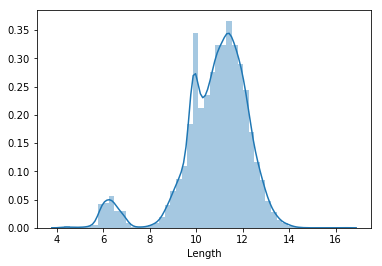

In [28]:
rpkm = pd.read_csv(outdir + '/rnaseq_matrix_condenseGenes_exons_rpkm.txt', sep='\t')
sns.distplot(np.log2(rpkm.Length + 1))

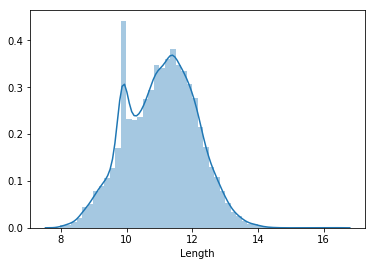

In [29]:
# Filter small mRNAs (transcriptsdd with length < 250 - mostly snoRNAs)
rpkm = rpkm.loc[rpkm.Length >= 250, :]
sns.distplot(np.log2(rpkm.Length + 1))

In [30]:
tpm_mat = process_rpkm(rpkm, conv_tpm=True)

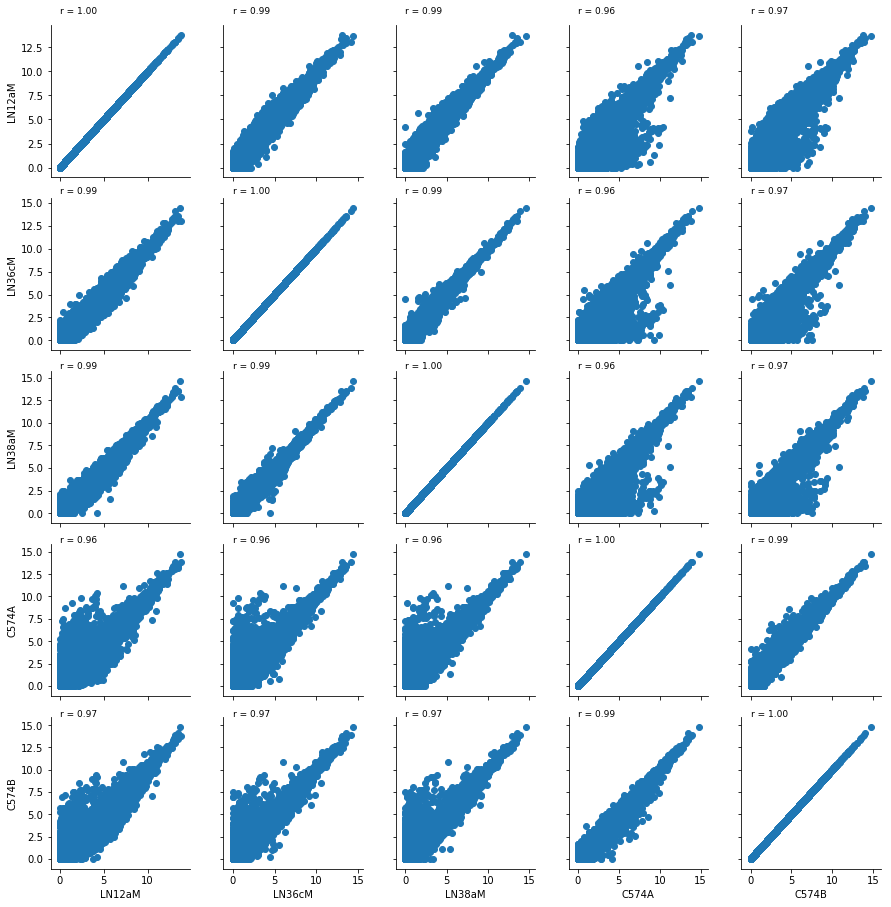

In [31]:
tpm_paired_scatter(tpm_mat, '', tissue='')

# Descriptive analysis of our data

In [32]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# standardize matrix, mean=0, std=1
tpm_std = StandardScaler().fit_transform(tpm_mat)
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF.group])).reset_index()
tpm_pca_df['mouse'] = samplesDF['mouse']

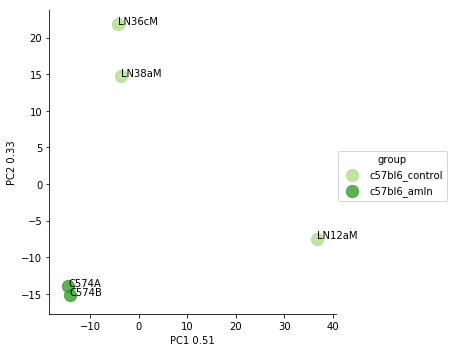

In [33]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group', palette=color_dict,
                size=5, scatter_kws={'s': 150})
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC1, tpm_pca_df.PC2, tpm_pca_df.mouse, plt.gca())

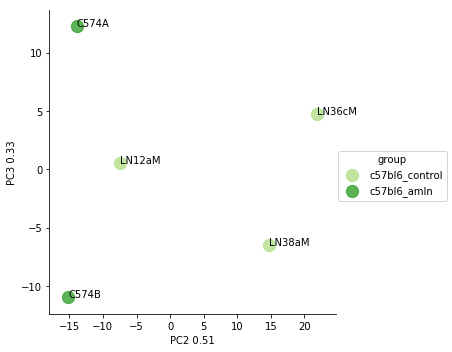

In [34]:
ax = sns.lmplot('PC2', 'PC3', tpm_pca_df, fit_reg=False,
                hue='group', palette=color_dict,
                size=5, scatter_kws={'s': 150})
ax.set(xlabel=('PC2 %.2f' % exp_var[0]), ylabel=('PC3 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC2, tpm_pca_df.PC3, tpm_pca_df.mouse, plt.gca())

In [35]:
transcript_pc = pd.DataFrame(pca.components_.T, tpm_mat.index, columns=['PC1','PC2','PC3'])

In [36]:
# look at the genes with the highest loading in PC1
transcript_pc.sort_values(by = 'PC1', ascending=False).head(10)

,PC1,PC2,PC3
RepeatID,,,
NM_007393,0.282717,-0.561196,0.286965
NM_010545,0.234817,-0.047130,-0.311963
NM_016917,0.170586,0.066623,-0.041795
NM_011520,0.141776,-0.010216,-0.088457
NM_007574,0.133903,0.249550,0.061800
NM_010442,0.131358,-0.009487,0.114686
NM_001037859,0.125843,0.051548,-0.081658
NM_010766,0.117747,0.043278,0.035594
NM_007572,0.110920,0.257948,0.204760


### Heatmap

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


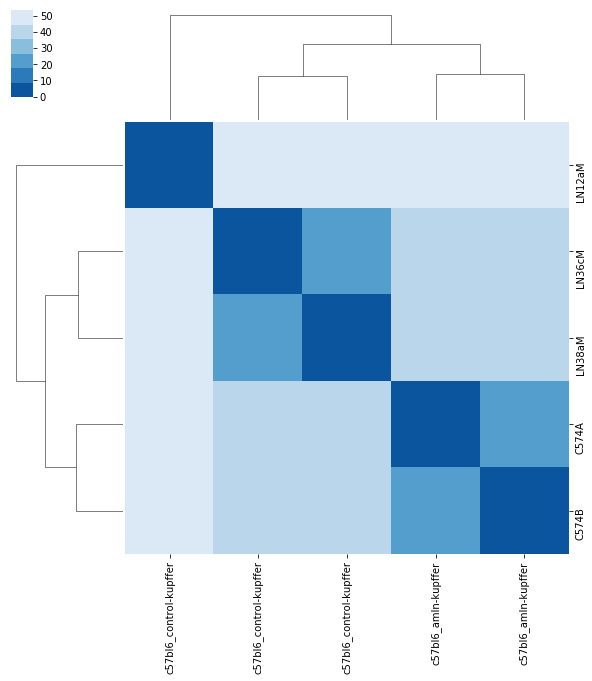

In [37]:
from scipy.spatial import distance
tpm_dist = pd.DataFrame(distance.squareform(distance.pdist(tpm_std.T, 'euclidean')),
                        columns = list(samplesDF.group_tissue),
                        index = list(samplesDF.mouse))
# plot values using sns clustermap - ignore error as we know we are putting in a distance mat
g = sns.clustermap(tpm_dist, cmap=sns.color_palette("Blues_r"))

## Differential Analysis (DESeq2)

### Prep data for R

In [38]:
raw_counts_file = '/rnaseq_matrix_condenseGenes_exons_raw.txt'
counts_df = pd.read_csv(outdir + raw_counts_file, sep='\t')

In [39]:
# import the raw count file
raw_counts_file = '/rnaseq_matrix_condenseGenes_exons_raw.txt'
counts_df = pd.read_csv(outdir + raw_counts_file, sep='\t')

# remove samples with length < 250bp
counts_df = counts_df.loc[counts_df.Length >= 250, :]

# create gene name column
counts_df['Gene'] = pd.Series([x.split('|')[0] for x in counts_df['Annotation/Divergence']])

# clean up columns
counts_df.columns = pd.Series(counts_df.columns)\
        .str.split(r" \(").str[0]\
        .str.split('/.*/').str[-1]
counts_df = counts_df.set_index('Transcript/RepeatID')

#### Write the data for DESeq2

In [40]:

# raw count matrix for DESeq
raw_counts_deseq = raw_counts_file.replace('.txt', '_mat_deseq.txt')
counts_df.iloc[:,7:-1].to_csv(outdir + raw_counts_deseq, sep='\t')

# Column Data Information for DESeq, make sure to drop the samples we are excluding
col_data = samplesDF.loc[:, ['subject', 'strain', 'diet', 'sample_type']]
col_data = col_data.set_index('subject')
col_file = raw_counts_file.replace('.txt', '_deseq_col_info.txt')
col_data.to_csv(outdir + col_file, sep='\t')

# ~*~* Since RPY2 isnt working this is we do DESeq2 in a magical notebook far far away ~*~*

# Import DESeq2 results

In [41]:
deseq = pd.read_csv(outdir + '/rnaseq_c57bl6_amln_1wk_deseq_results.txt', sep=',')

In [42]:
deseq.head(20)

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,NM_001305585,1375.746589,5.224745,0.228069,22.908651,3.809563e-116,5.508629e-112
1,NM_009244,1400.210270,6.634121,0.306582,21.638991,7.717348e-104,5.579643e-100
2,NM_009692,2306.523725,6.675785,0.324339,20.582729,3.919818e-94,1.889352e-90
3,NM_001159487,866.053013,6.693674,0.329004,20.345252,5.114876e-92,1.849028e-88
4,NM_009246,814.967764,6.548752,0.335902,19.495995,1.187224e-84,3.433452e-81
5,NM_001162938,402.814440,6.449320,0.341850,18.865920,2.174532e-79,5.240621e-76
6,NM_001039544,2697.796352,6.493136,0.355011,18.289974,9.946166e-75,2.054594e-71
7,NM_010006,414.116807,7.033293,0.387692,18.141442,1.500409e-73,2.711990e-70
8,NM_013697,1038.011983,5.632849,0.313971,17.940675,5.676124e-72,9.119638e-69
9,NM_011458,5356.779637,6.584275,0.373526,17.627355,1.519100e-69,2.196618e-66


In [1]:
counts_df.loc[deseq['Unnamed: 0'].head(20), :]

NameError: name 'counts_df' is not defined

* **Serpina1**: Humans: expressed consituitively in monocytes and graunulocytes, repressed in monocyte derived macrophages in CSF1, and strongly induced as a late response gene upon addition of LPS. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4510422/, mouse serpina1b and serpina1d are homologues.
* **Ifi208**: also known as Pydc3, which is thought to function as an anti-inflammasome compound.

Generally it seems that we see upregulation in the apolipoprotein genes and in the Serpin gene family. Unclear how to make heads or tails of this. The browser tracks are pretty impressive for these genes, pretty much complete upregulation from almost no baseline expression.

### Write for analysis with metascape

In [44]:
gene_list = {}
pval = 0.01
# gene_list[str(pval)+'_up'] = list(counts_df.loc[deseq.loc[((deseq.padj <= pval) & (deseq.log2FoldChange > 0)),
#                                                           'Unnamed: 0'], 'Gene'].dropna())
# gene_list[str(pval)+'_dn'] = list(counts_df.loc[deseq.loc[((deseq.padj <= pval) & (deseq.log2FoldChange < 0)),
#                                                           'Unnamed: 0'], 'Gene'].dropna())
gene_list[str(pval)+'_up_fc2'] = list(counts_df.loc[deseq.loc[((deseq.padj <= pval) & (deseq.log2FoldChange > 2)),
                                                          'Unnamed: 0'], 'Gene'].dropna())
gene_list[str(pval)+'_dn_fc2'] = list(counts_df.loc[deseq.loc[((deseq.padj <= pval) & (deseq.log2FoldChange < -2)),
                                                          'Unnamed: 0'], 'Gene'].dropna())

In [45]:
import csv
import itertools
# write output for uploading to metascape
with open(outdir + "deseq_gene_list.csv", "w") as outfile:
   writer = csv.writer(outfile)
   writer.writerow(gene_list.keys())
   writer.writerows(itertools.zip_longest(*gene_list.values()))

### Metascape analysis so far appears inconclusive, no enrichment pathways appear to pass multiple testing correction

...

# Follow up question, what happens to the genes that are up by fc > 2 at 1 wk at 30 weeks?
To do this we have to first get the tim4 pos and tim4 neg gene expression levels set up

In [46]:
# define samples for both whole liver and kupffer
samples_c57_tim4 = {'kupffer':["NCoRWT_KupfferTim4Neg_RNA_polyA_AMLNDiet_30week_LN144B_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Neg_RNA_polyA_AMLNDiet_30week_LN146C_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Neg_RNA_polyA_AMLNDiet_30week_LN152B_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN144B_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN146D_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN146C_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN152B_JSS_TDT_16_10_20"]}

In [47]:
# define sample data frame
samplesDF_c57_tim4 = pd.DataFrame([s for groups in samples_c57_tim4.values() for s in groups], columns = ['subject'])
samplesDF_c57_tim4['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF_c57_tim4.subject]
samplesDF_c57_tim4['path'] = [datapath[key] + s for key in datapath.keys() for s in samples_c57_tim4[key]]
samplesDF_c57_tim4['batch'] = pd.factorize(samplesDF_c57_tim4.subject\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]
samplesDF_c57_tim4['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF_c57_tim4.subject]
samplesDF_c57_tim4['strain'] = samplesDF_c57_tim4['strain'].replace('ncorwt', 'c57bl6')
samplesDF_c57_tim4['genotype'] = ['tim4pos' if 'Pos' in name else 'tim4neg' for name in samplesDF_c57_tim4.subject]
samplesDF_c57_tim4['exclusion'] = samplesDF_c57_tim4.subject.str.contains('|'.join(bad_samples.keys()),
                                                       flags=re.IGNORECASE)
samplesDF_c57_tim4['mouse'] = samplesDF_c57_tim4.subject.str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                     flags=re.IGNORECASE, expand=False)

In [48]:
# set analyses we want to do 
# No longer include genes. After discussion with Ty Troutman running analyzeRepeats with
# the 'condenseGenes' flag will collapse transcripts into one. Thus the ideal way to do
# RNA Seq for now is 'exons' - count only in exons, along with condenseGenes.
analyses = [('exons', False, None),
            ('exons', True, None),
            ('exons', False, 'rlog'), # ignore the rlog transform values for now
            ('exons', False, 'rpkm')]

In [49]:
# run annotate repeats with set of analysis options
for count_type, raw, norm in analyses:
    
    # generate file name
    filename = outdir + '/c57_tim4_rnaseq_matrix_condenseGenes_' + count_type
    if raw:
        filename += '_raw'
    if norm != None:
        filename += ('_'+ str(norm))
    filename += '.txt'
    
    # run annotate repeats
    if not os.path.isfile(filename):
        out, err = hbUtils.run_annotateRepeats(samplesDF_c57_tim4.path,
                countType=count_type, raw=raw, norm=norm, print_out=True)
        f = open(filename, 'w')
        f.write(out.decode('utf-8'))
        f.close()
        print(err.decode('utf-8'))

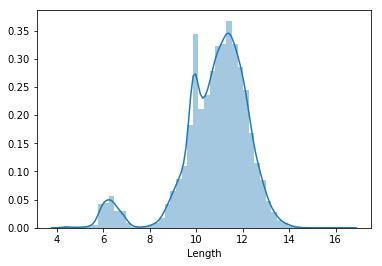

In [50]:
rpkm_c57_tim4 = pd.read_csv(outdir + '/c57_tim4_rnaseq_matrix_condenseGenes_exons_rpkm.txt', sep='\t')
sns.distplot(np.log2(rpkm_c57_tim4.Length + 1))

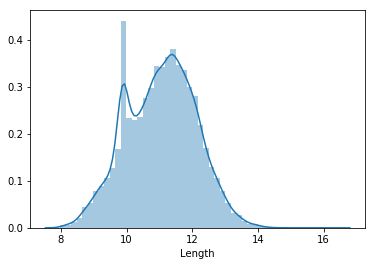

In [51]:
# Filter small mRNAs (transcriptsdd with length < 250 - mostly snoRNAs)
rpkm_c57_tim4 = rpkm_c57_tim4.loc[rpkm_c57_tim4.Length >= 250, :]
sns.distplot(np.log2(rpkm_c57_tim4.Length + 1))

In [52]:
tpm_mat_c57_tim4 = process_rpkm(rpkm_c57_tim4, conv_tpm=True)

### PCA

In [53]:
tpm_mat_c57_tim4.shape

(23192, 7)

In [55]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# standardize matrix, mean=0, std=1
tpm_std = StandardScaler().fit_transform(tpm_mat_c57_tim4)
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF_c57_tim4.genotype])).reset_index()
tpm_pca_df['mouse'] = samplesDF_c57_tim4['mouse']

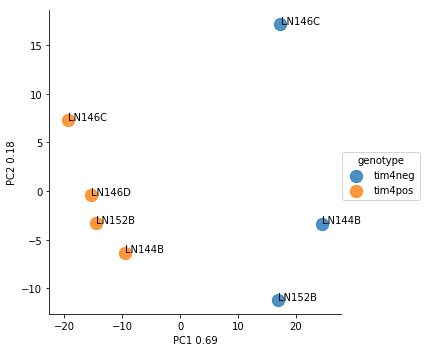

In [56]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='genotype',
                size=5, scatter_kws={'s': 150})
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC1, tpm_pca_df.PC2, tpm_pca_df.mouse, plt.gca())

Samples look pretty good, no obvious outliers

In [57]:
tpm_mat_c57_tim4_fc2_up = tpm_mat_c57_tim4.reindex(
    deseq.loc[(deseq.log2FoldChange >= 2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')
tpm_mat_c57_tim4_fc2_dn = tpm_mat_c57_tim4.reindex(
    deseq.loc[(deseq.log2FoldChange <= -2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')

In [58]:
tpm_mat_fc2_up = tpm_mat.reindex(
    deseq.loc[(deseq.log2FoldChange >= 2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')
tpm_mat_fc2_dn = tpm_mat.reindex(
    deseq.loc[(deseq.log2FoldChange <= -2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')

In [59]:
# merge and process fc up
fc2_up = pd.merge(tpm_mat_c57_tim4_fc2_up, tpm_mat_fc2_up,
                  left_index=True, right_index=True)
fc2_up = fc2_up.melt()

In [60]:
fc2_up['log2_rpkm'] = np.log2(fc2_up.value + 1)
fc2_up['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in fc2_up.variable]
fc2_up['diet'] = ['amln' if 'AMLN' in x else 'control' for x in fc2_up.variable]
fc2_up['tim4'] = ['tim4pos' if 'Pos' in x else 'tim4neg' for x in fc2_up.variable]
fc2_up['group'] = fc2_up.tim4 + '_' + fc2_up.diet

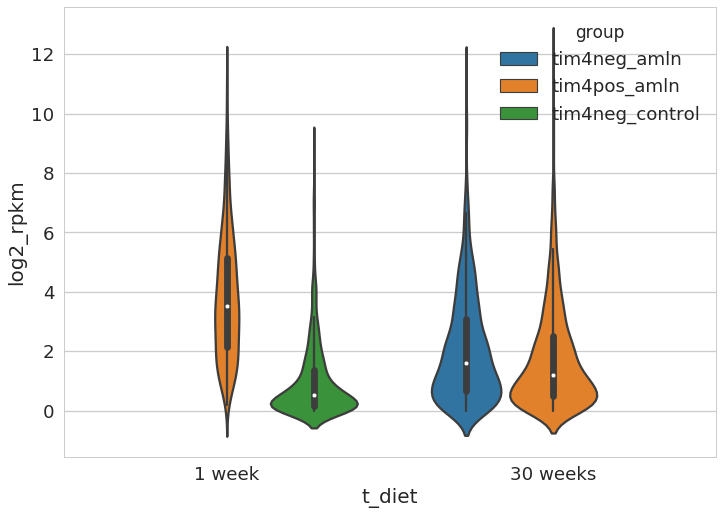

In [61]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='t_diet', y='log2_rpkm', hue='group',
               order= ['1 week', '30 weeks'], data=fc2_up)

In [145]:
from scipy import stats
print(stats.ranksums(
    fc2_up.loc[(fc2_up['t_diet'] == '1 week') & (fc2_up['group'] == 'tim4neg_control'), 'value'],
    fc2_up.loc[(fc2_up['t_diet'] == '1 week') & (fc2_up['group'] == 'tim4pos_amln'), 'value']))

print(stats.ranksums(
    fc2_up.loc[(fc2_up['t_diet'] == '30 weeks') & (fc2_up['group'] == 'tim4neg_amln'), 'value'],
    fc2_up.loc[(fc2_up['t_diet'] == '30 weeks') & (fc2_up['group'] == 'tim4pos_amln'), 'value']))

RanksumsResult(statistic=-34.059188169062303, pvalue=2.9674792719087292e-254)
RanksumsResult(statistic=5.6815987089929516, pvalue=1.3344146292720432e-08)


So it looks like the upregulated genes on 1 week of diet are also more highly expressed in timd4 negative Kupffer cells at 30 weeks

In [141]:
# merge and dnrocess fc dn
fc2_dn = pd.merge(tpm_mat_c57_tim4_fc2_dn, tpm_mat_fc2_dn,
                  left_index=True, right_index=True)
fc2_dn = fc2_dn.melt()

In [142]:
fc2_dn['log2_rpkm'] = np.log2(fc2_dn.value + 1)
fc2_dn['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in fc2_dn.variable]
fc2_dn['diet'] = ['amln' if 'AMLN' in x else 'control' for x in fc2_dn.variable]
fc2_dn['tim4'] = ['tim4pos' if 'Pos' in x else 'tim4neg' for x in fc2_dn.variable]
fc2_dn['group'] = fc2_dn.tim4 + '_' + fc2_dn.diet

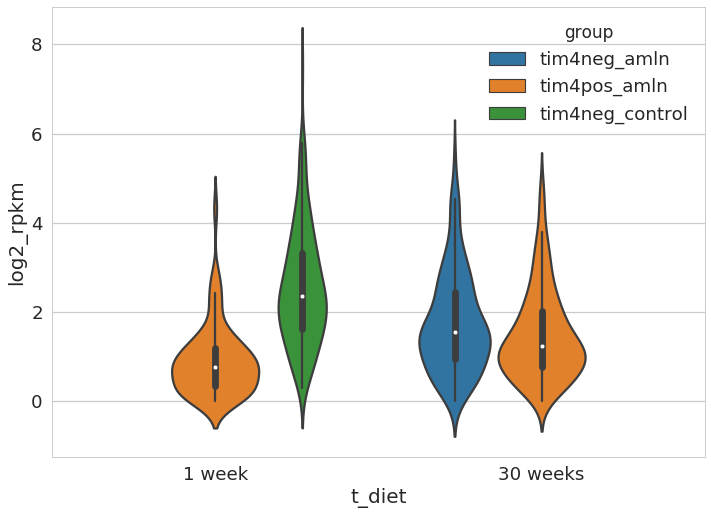

In [143]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='t_diet', y='log2_rpkm', hue='group',
               order= ['1 week', '30 weeks'], data=fc2_dn)

In [144]:
from scipy import stats
print(stats.ranksums(
    fc2_dn.loc[(fc2_dn['t_diet'] == '1 week') & (fc2_dn['group'] == 'tim4neg_control'), 'value'],
    fc2_dn.loc[(fc2_dn['t_diet'] == '1 week') & (fc2_dn['group'] == 'tim4pos_amln'), 'value']))

print(stats.ranksums(
    fc2_dn.loc[(fc2_dn['t_diet'] == '30 weeks') & (fc2_dn['group'] == 'tim4neg_amln'), 'value'],
    fc2_dn.loc[(fc2_dn['t_diet'] == '30 weeks') & (fc2_dn['group'] == 'tim4pos_amln'), 'value']))

RanksumsResult(statistic=11.697519458045209, pvalue=1.3123372408818343e-31)
RanksumsResult(statistic=2.782099118418218, pvalue=0.00540085425921852)


This is showing that the genes that are down in the 1 week NASH model are also slightly increased in tim4negative cells

Its interesting that both of these gene sets are up in 30 week tim4 negative kupffer cells compared to tim4 positive kupffer cells

# Lets compare the kupffer cell specific gene list...

In [146]:
# read in Jason's 150 Kupffer cell specific genes
file = open('/home/h1bennet/liverStrains/data/mouse/KC_Specific_Genes150.txt')
kc_spec_genes = file.read().split('\n')

In [147]:
# get the index of values with the kc specific genes
kc_spec_index = counts_df['Annotation/Divergence'].str.match(
    '|'.join([s + '\|' for s in kc_spec_genes]), flags=re.IGNORECASE)

In [148]:
# re-index the tpms with the KC specific genes
tpm_mat_c57_tim4_kupffer = tpm_mat_c57_tim4.reindex(list(counts_df.loc[kc_spec_index, :].index))
tpm_mat_kupffer = tpm_mat.reindex(list(counts_df.loc[kc_spec_index, :].index))

In [129]:
# merge and dnrocess fc dn
kupffer_genes = pd.merge(tpm_mat_c57_tim4_kupffer, tpm_mat_kupffer,
                  left_index=True, right_index=True)

# melt
kupffer_genes = kupffer_genes.melt()

In [131]:
# categorize samples
kupffer_genes['log2_rpkm'] = np.log2(kupffer_genes.value + 1)
kupffer_genes['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in kupffer_genes.variable]
kupffer_genes['diet'] = ['amln' if 'AMLN' in x else 'control' for x in kupffer_genes.variable]
kupffer_genes['tim4'] = ['tim4pos' if 'Pos' in x else 'tim4neg' for x in kupffer_genes.variable]
kupffer_genes['group'] = kupffer_genes.tim4 + '_' + kupffer_genes.diet

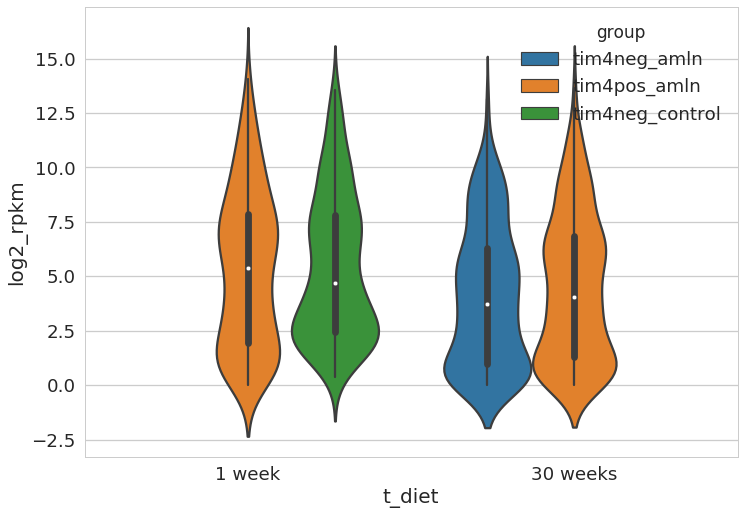

In [134]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='t_diet', y='log2_rpkm', hue='group',
               order= ['1 week', '30 weeks'], data=kupffer_genes)

In [138]:
from scipy import stats
print(stats.ranksums(
    kupffer_genes.loc[(kupffer_genes['t_diet'] == '1 week') & (kupffer_genes['group'] == 'tim4neg_control'), 'value'],
    kupffer_genes.loc[(kupffer_genes['t_diet'] == '1 week') & (kupffer_genes['group'] == 'tim4pos_amln'), 'value']))

print(stats.ranksums(
    kupffer_genes.loc[(kupffer_genes['t_diet'] == '30 weeks') & (kupffer_genes['group'] == 'tim4neg_amln'), 'value'],
    kupffer_genes.loc[(kupffer_genes['t_diet'] == '30 weeks') & (kupffer_genes['group'] == 'tim4pos_amln'), 'value']))


RanksumsResult(statistic=0.36001373591229774, pvalue=0.71883686158284976)
RanksumsResult(statistic=-1.7738682192751933, pvalue=0.076084950679877278)


# One question that might be interesting: are the gene expression profiles for genes that are significantly different at 1 wk more similar to the expression profiles in balb/aj at 30 wks compared to ncorwt?

In [185]:
# load in RPKM from all strains experiment
rpkm_strains = pd.read_csv(
    '/home/h1bennet/liverStrains/results/180111_RNA_Seq/rnaseq_matrix_condenseGenes_exons_rpkm.txt',
    sep='\t')
# subset kupffer cell data
rpkm_strains = hbUtils.df_col_subset(rpkm_strains, 'kupffer')
# clean up index column
rpkm_strains.columns.values[0] = 'Transcript/RepeatID'
rpkm_strains = rpkm_strains.set_index('Transcript/RepeatID')
# convert to tpm
tpm_strains = rpkm_strains

In [186]:
tpm_mat_strains_fc2_up = tpm_strains.reindex(
    deseq.loc[(deseq.log2FoldChange >= 2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')
tpm_mat_strains_fc2_dn = tpm_strains.reindex(
    deseq.loc[(deseq.log2FoldChange <= -2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')

In [191]:
# process fc2 up
strains_fc2_up = tpm_mat_strains_fc2_up.melt()

In [189]:
strains_fc2_up['log2_rpkm'] = np.log2(strains_fc2_up.value + 1)
strains_fc2_up['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in strains_fc2_up.variable]
strains_fc2_up['diet'] = ['amln' if 'AMLN' in x else 'control' for x in strains_fc2_up.variable]
strains_fc2_up['strain'] = ['balb' if 'balb' in x else 'aj' if 'aj' in x else 'c57bl6' for x in strains_fc2_up.variable]
strains_fc2_up['group'] = strains_fc2_up.strain + '_' + strains_fc2_up.diet

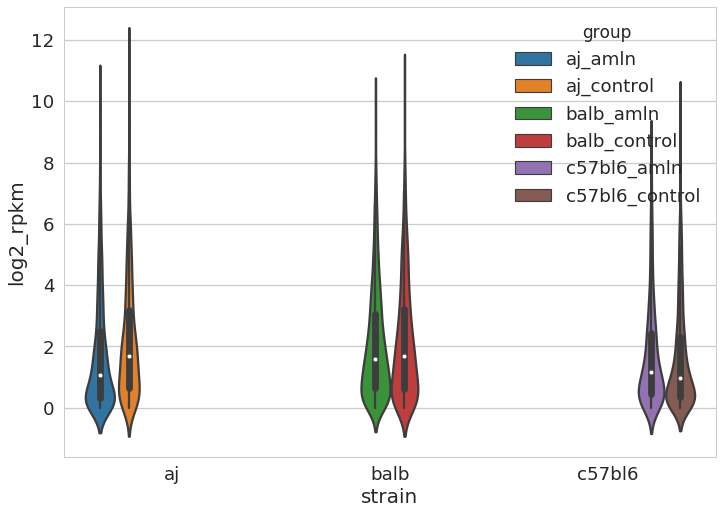

In [190]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='strain', y='log2_rpkm', hue='group', data=strains_fc2_up)

In [192]:
tpm_mat_strains_fc2_dn = tpm_strains.reindex(
    deseq.loc[(deseq.log2FoldChange >= 2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')
tpm_mat_strains_fc2_dn = tpm_strains.reindex(
    deseq.loc[(deseq.log2FoldChange <= -2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')

In [194]:
# process fc2 up
strains_fc2_dn = tpm_mat_strains_fc2_dn.melt()

In [195]:
strains_fc2_dn['log2_rpkm'] = np.log2(strains_fc2_dn.value + 1)
strains_fc2_dn['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in strains_fc2_dn.variable]
strains_fc2_dn['diet'] = ['amln' if 'AMLN' in x else 'control' for x in strains_fc2_dn.variable]
strains_fc2_dn['strain'] = ['balb' if 'balb' in x else 'aj' if 'aj' in x else 'c57bl6' for x in strains_fc2_dn.variable]
strains_fc2_dn['group'] = strains_fc2_dn.strain + '_' + strains_fc2_dn.diet

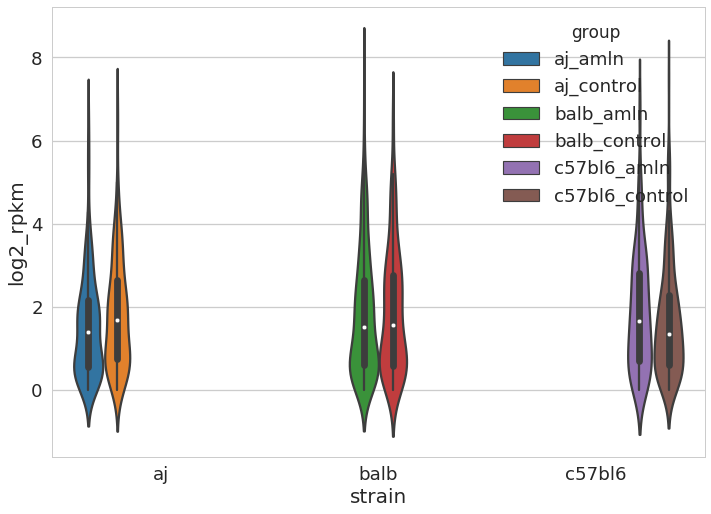

In [196]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='strain', y='log2_rpkm', hue='group', data=strains_fc2_dn)